In [1]:
from scipy.stats import gaussian_kde
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import scipy.signal


from matplotlib import rc
plt.rcParams.update({ "text.usetex": True, "font.family": "serif", "font.serif": ["computer modern roman"], "font.size": 16})
plw = 0.6
pcs = 3
pms = 3
bfillc = [0.9,0.9,0.9]
plt.rcParams['axes.linewidth'] = plw
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = plw
plt.rcParams['xtick.minor.width'] = plw
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.major.size'] = 4.5
plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.major.width'] = plw
plt.rcParams['ytick.minor.width'] = plw
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.major.size'] = 5
plt.rcParams["figure.figsize"] = (5,4)



# define custom color scheme
colors = [plt.cm.Spectral(i/float(10-1)) for i in range(20)]

#for i in range(10):
#    plt.scatter(i, i, color=colors[i], s=500)

cs = {
    "Bordeaux": colors[0],
    "Light Red": colors[1],
    "Orange": colors[2],
    "Gold": colors[3],
    "Yellow": colors[4],
    "Lime": colors[5],
    "Light Green": colors[6],
    "Teal": colors[7],
    "Blue": colors[8],
    "Purple": colors[9]
}


2025-02-24 13:34:33.306692: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Set dimensionality of configurational space 
ND=100

# Generate clustered data
def generate_clustered_data(n_samples=1200):
    # Create three clusters in ND space
    centers = [
        np.random.normal(0, 1, ND),
        np.random.normal(1, 2, ND),
        np.random.normal(-2, 3, ND),
        np.random.normal(-3, 1, ND),
    ]
    
    data = []
    for center in centers:
        #cluster = np.random.normal(center, 1, (n_samples //  np.random.randint(2, 10+1),  ND))
        cluster = np.random.normal(center, 4, (n_samples //  4,  ND))
        data.append(cluster)
        #background = np.random.uniform(center, 1, (n_samples // 20 ,  ND))
        #data.append(background)
        
    return np.vstack(data)

# Create and train the autoencoder
def create_autoencoder(input_dim=ND, encoding_dim=2):
    # Encoder
    encoder_input = tf.keras.Input(shape=(input_dim,))
    encoder_hidden1 = tf.keras.layers.Dense(16, activation='relu')(encoder_input)  # More neurons
    encoder_hidden2 = tf.keras.layers.Dense(8, activation='relu')(encoder_hidden1)  # Extra layer
    encoder_output = tf.keras.layers.Dense(encoding_dim)(encoder_hidden2)  # Bottleneck layer
    
    # Decoder
    decoder_hidden1 = tf.keras.layers.Dense(8, activation='relu')(encoder_output)  # Extra layer
    decoder_hidden2 = tf.keras.layers.Dense(16, activation='relu')(decoder_hidden1)  # More neurons
    decoder_output = tf.keras.layers.Dense(input_dim)(decoder_hidden2)  # Output layer
    
    # Full autoencoder model
    autoencoder = tf.keras.Model(encoder_input, decoder_output)
    
    # Separate encoder
    encoder = tf.keras.Model(encoder_input, encoder_output)
    
    return autoencoder, encoder

# Compute Jacobian for a given input point
def compute_jacobian(encoder, input_point):
    input_point = tf.cast(input_point, tf.float32)
    input_point = tf.reshape(input_point, (1, -1))
    
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(input_point)
        output = encoder(input_point)
    
    # Initialize Jacobian matrix
    jacobian = np.zeros((2, ND))  # 2×10 matrix for our case
    
    # Compute gradients for each output dimension
    for i in range(2):
        grads = tape.gradient(output[:, i], input_point)
        if grads is not None:
            jacobian[i] = grads.numpy()
    
    return jacobian

In [3]:
# Generate data
data = generate_clustered_data()

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data).astype(np.float32)

# Create your autoencoder model
autoencoder, encoder = create_autoencoder(input_dim=ND, encoding_dim=2)

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


/var/folders/4v/jxb311rn5nq2q59y91zzgxd40000gp/T/ipykernel_33123/3505278212.py:97: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(encoded_data[:300, 0], encoded_data[:300, 1],c=colors[0], alpha=0.5, s=5 )
/var/folders/4v/jxb311rn5nq2q59y91zzgxd40000gp/T/ipykernel_33123/3505278212.py:98: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(encoded_data[300:600, 0], encoded_data[300:600, 1],c=colors[8], alpha=0

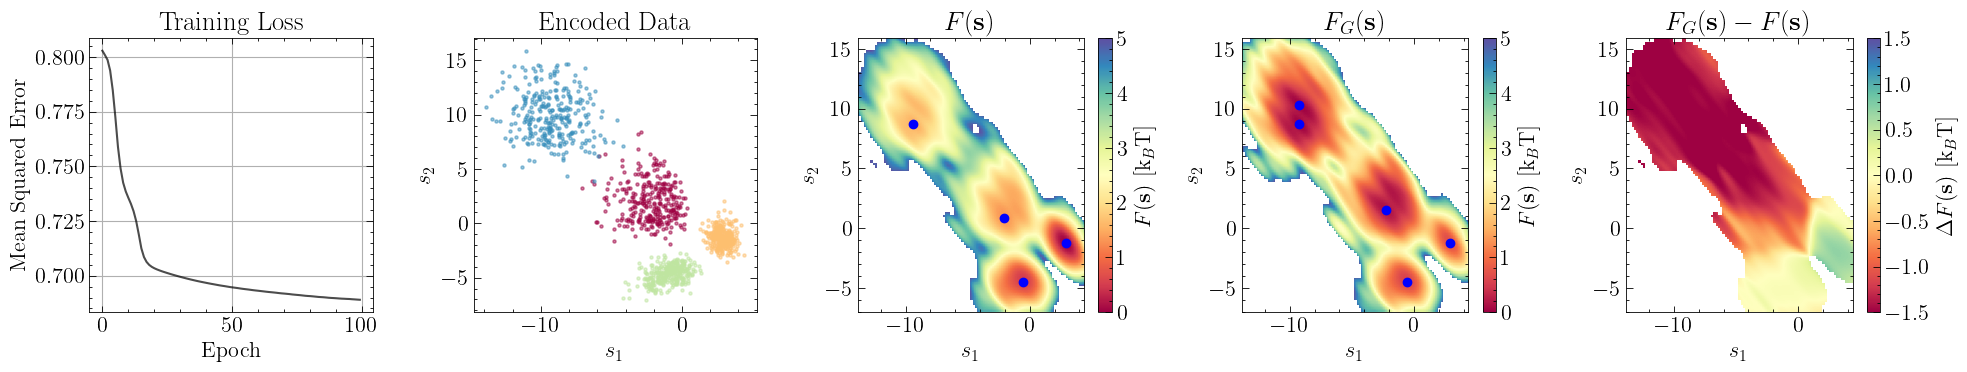

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step


/var/folders/4v/jxb311rn5nq2q59y91zzgxd40000gp/T/ipykernel_33123/3505278212.py:97: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(encoded_data[:300, 0], encoded_data[:300, 1],c=colors[0], alpha=0.5, s=5 )
/var/folders/4v/jxb311rn5nq2q59y91zzgxd40000gp/T/ipykernel_33123/3505278212.py:98: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(encoded_data[300:600, 0], encoded_data[300:600, 1],c=colors[8], alpha=0

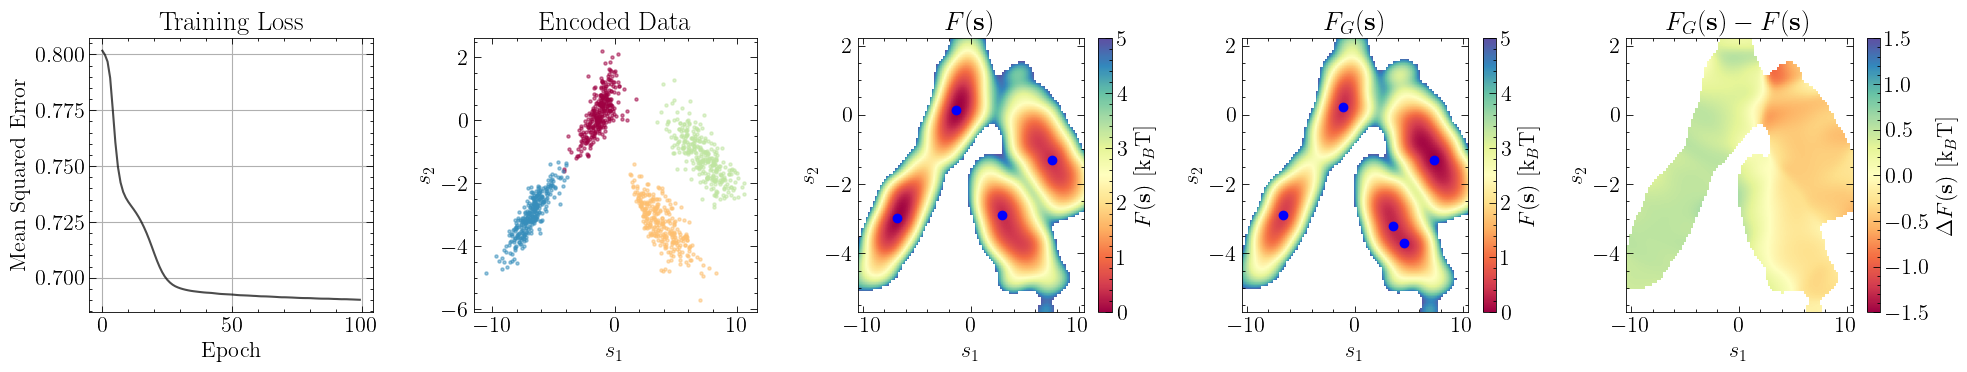

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step


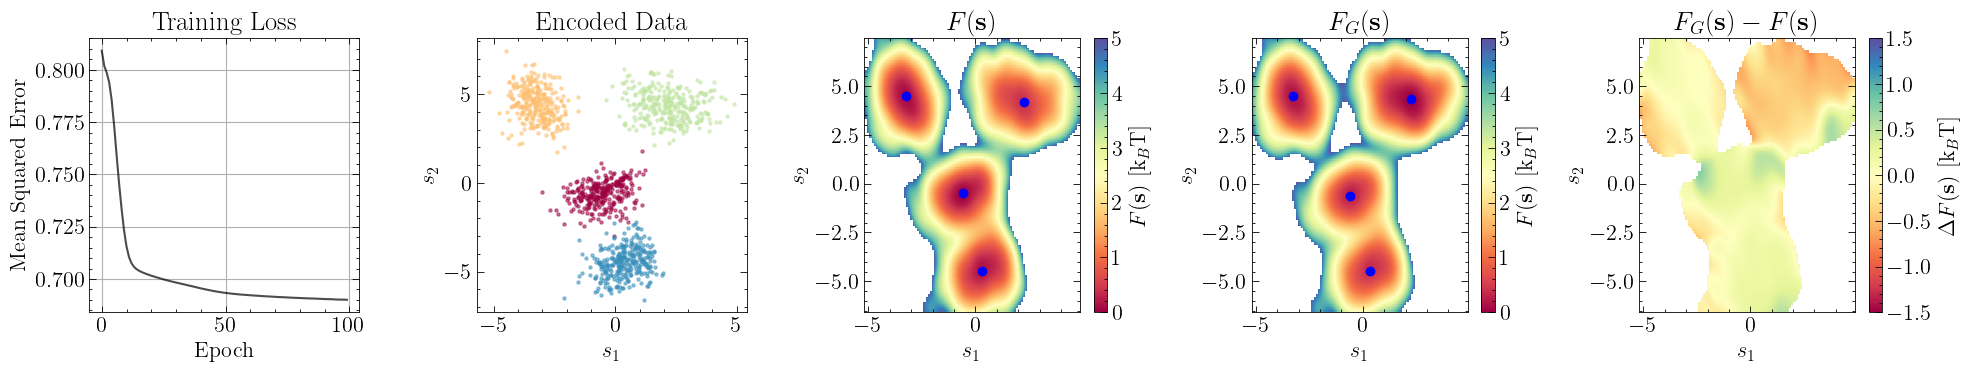

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step


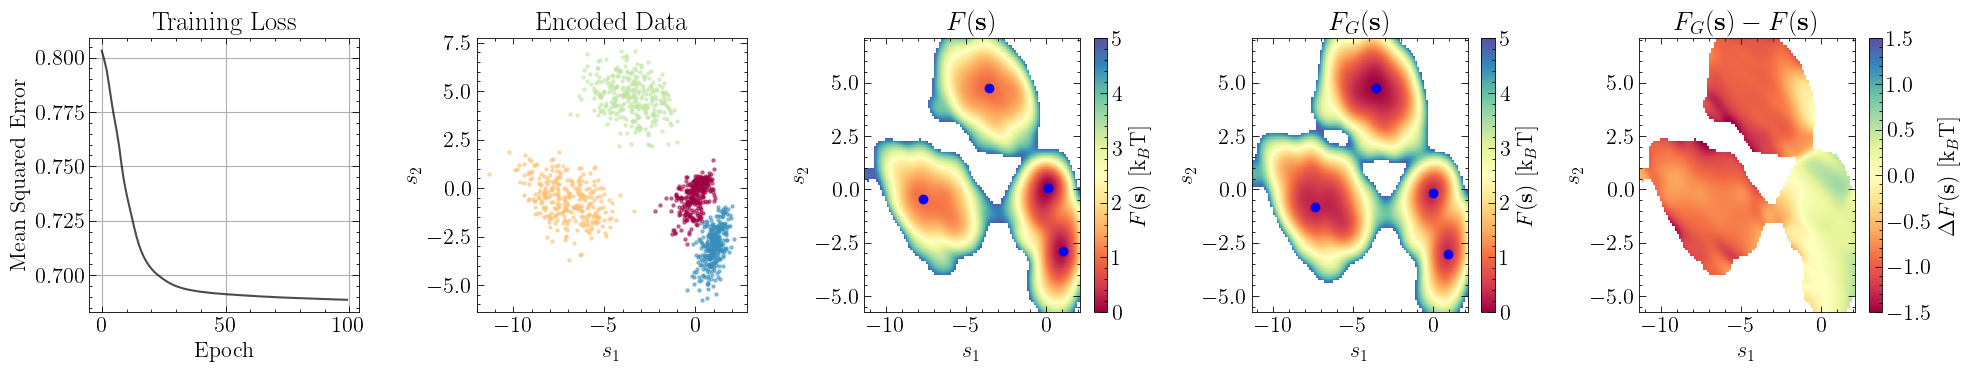

In [4]:
niter=0
histogram = 0
niter=0
deltas_FG=[]
deltas_F=[]

while niter<4: 
    

    
    # Create and compile the autoencoder
    autoencoder, encoder = create_autoencoder()
    autoencoder.compile(optimizer='adam', loss='mae')
    
    # Train the autoencoder
    history = autoencoder.fit(
        data_scaled, 
        data_scaled,
        epochs=100,
        batch_size=100,
        shuffle=True,
        verbose=0
    )

    plt.subplots(1, 5, figsize=(20, 4))
    plt.subplot(1, 5, 1)
    plt.plot(history.history['loss'],'k',alpha=0.7)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.grid(True)
    
    # Encode the data to 2D
    encoded_data = encoder.predict(data_scaled)
    
    # Compute Jacobian at several points
    sample_points = data_scaled[::1]  # Take every 50th point
    jacobians = np.array([compute_jacobian(encoder, point) for point in sample_points])
    
    # Encode the data to 2D
    encoded_data = encoder.predict(data_scaled)

    sample_points = data_scaled[::1]  # Take every datapoint

##########################################################################################
    # Jacobian: Inefficient but I know what it's doing
    #i=0
    #w_g=np.zeros(np.shape(sample_points)[0])
    #for point in sample_points:        
    #    x = tf.reshape(tf.convert_to_tensor(point),(1, ND))
    #    
    #    # Compute the Jacobian using tf.GradientTape
    #    with tf.GradientTape() as tape:
    #        tape.watch(x)
    #        encoded_output = encoder(x)  # Forward pass through encoder
    #    
    #    jacobian = tape.jacobian(encoded_output, x).numpy().squeeze() 
    #    singular_values = np.linalg.svd(jacobian, compute_uv=False)
    #    w_g[int(i)] = np.prod(singular_values)
    #    print(w_g[i])
    #    i=i+1
##########################################################################################    
    # Jacobian using tensorflow black magic
    # Convert all points to tensor at once
    x_batch = tf.convert_to_tensor(sample_points, dtype=tf.float32)
    
    # Compute Jacobian for entire batch
    with tf.GradientTape() as tape:
        tape.watch(x_batch)
        encoded_output = encoder(x_batch)
    
    # Get Jacobian for all points at once
    batch_jacobian = tape.jacobian(encoded_output, x_batch)
    
    # Extract just the correct Jacobian for each point using tf.linalg.diag_part
    # not sure I fully get what this is doing.
    
    batch_size = x_batch.shape[0]
    jacobians = tf.zeros((batch_size, 2, ND))
    for i in range(batch_size):
        # tf.tensor_scatter_nd_update is used to update specific indices of a tensor.
        # The first argument is jacobians, which is the tensor being updated.
        # The second argument is [[i]], which specifies the indices to update. This means the update will be done at the i-th row of the batch.
        # The third argument is [batch_jacobian[i, :, i, :]], which extracts a specific Jacobian slice from batch_jacobian (specifically the Jacobian for the i-th sample). batch_jacobian seems to be a tensor with a shape of (batch_size, 2, ND, batch_size) (likely representing some batch of Jacobians).
        # The value at batch_jacobian[i, :, i, :] is assigned to the i-th position in the jacobians tensor.
            jacobians,
            [[i]],
            [batch_jacobian[i, :, i, :]]
        )
    
    # Compute SVD for all Jacobians at once
    s = tf.linalg.svd(jacobians, compute_uv=False)
    
    # Compute product of singular values for each point
    w_g = tf.reduce_prod(s, axis=1).numpy() + 1E-10

    # First, let's get the range of our encoded data
    x_min, x_max = encoded_data[:, 0].min(), encoded_data[:, 0].max()
    y_min, y_max = encoded_data[:, 1].min(), encoded_data[:, 1].max()

    # Scatter plot
    plt.subplot(1, 5, 2)
    plt.scatter(encoded_data[:300, 0], encoded_data[:300, 1],c=colors[0], alpha=0.5, s=5 )
    plt.scatter(encoded_data[300:600, 0], encoded_data[300:600, 1],c=colors[8], alpha=0.5, s=5 )
    plt.scatter(encoded_data[600:900, 0], encoded_data[600:900, 1], c=colors[3], alpha=0.5, s=5)
    plt.scatter(encoded_data[900:, 0], encoded_data[900:, 1], c=colors[6], alpha=0.5, s=5)
    plt.title('Encoded Data')
    plt.xlabel('$s_1$')
    plt.ylabel('$s_2$')
    
    if histogram == 1: 
        # Create 2D histogram with weights
        hist, xedges, yedges = np.histogram2d(
            encoded_data[:, 0], 
            encoded_data[:, 1],
            bins=30,  # You can adjust this for different granularity
            range=[[x_min, x_max], [y_min, y_max]],
            weights=w_g/np.sum(w_g)  # Using the Jacobian determinants as weights
        )
        
        # Create 2D histogram with weights
        hist_uw, xedges, yedges = np.histogram2d(
            encoded_data[:, 0], 
            encoded_data[:, 1],
            bins=30,  # You can adjust this for different granularity
            range=[[x_min, x_max], [y_min, y_max]]
        )
           
        # Weighted histogram
        plt.subplot(1, 5, 3)
        plt.imshow(
            -np.log(hist_uw.T)-np.min(-np.log(hist_uw.T)),  # Transpose because imshow uses different axis convention
            extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
            origin='lower',
            aspect='auto',
            cmap='Spectral',
            vmin=0,  # Set minimum color limit
            vmax=5  # Set maximum color limit (adjust as needed)
        )
        plt.colorbar(label='$F(\mathbf{s})$ [k$_B$T]')
        plt.title('$F(\mathbf{s})$')
        plt.xlabel('$s_1$')
        plt.ylabel('$s_2$')
        
        # Weighted histogram
        plt.subplot(1, 5, 4)
        plt.imshow(
            -np.log(hist.T)-np.min(-np.log(hist.T)),  # Transpose because imshow uses different axis convention
            extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
            origin='lower',
            aspect='auto',
            cmap='Spectral',
            vmin=0,  # Set minimum color limit
            vmax=5 # Set maximum color limit (adjust as needed)
        )
        plt.colorbar(label='$F_G(\mathbf{s})$ [k$_B$T]')
        plt.title('$F_G(\mathbf{s})$')
        plt.xlabel('$s_1$')
        plt.ylabel('$s_2$')
        plt.tight_layout()
    else:         
        # Assume encoded_data contains two columns: s1 and s2
        s1, s2 = encoded_data[:, 0], encoded_data[:, 1]
        
        # Compute weighted KDE
        values = np.vstack([s1, s2])  # Stack into 2D array
        kde = gaussian_kde(values, weights=w_g)  # Apply weights
        kde.set_bandwidth(bw_method=kde.factor * 0.5)
        kde_uw = gaussian_kde(values)  # unweighted
        kde_uw.set_bandwidth(bw_method=kde_uw.factor * 0.5)
        
        # Create a grid for evaluation
        x_grid = np.linspace(x_min, x_max, 100)
        y_grid = np.linspace(y_min, y_max, 100)
        X, Y = np.meshgrid(x_grid, y_grid)
        positions = np.vstack([X.ravel(), Y.ravel()])  # Flatten grid
        
        # Evaluate KDEs on the grid
        Z = kde(positions).reshape(X.shape)
        FG=-np.log(Z.T) - np.min(-np.log(Z.T))
        FG[FG>5]=np.nan
        Zuw = kde_uw(positions).reshape(X.shape)
        F=-np.log(Zuw.T) - np.min(-np.log(Zuw.T))
        F[F>5]=np.nan
    
      
        # Plot KDE using imshow
        plt.subplot(1, 5, 4)
        plt.imshow(
            FG.T,  
            extent=[x_min, x_max, y_min, y_max],
            origin='lower',
            aspect='auto',
            cmap='Spectral',
            vmin=0,  # Set minimum color limit
            vmax=5   # Set maximum color limit (adjust as needed)
        )
        plt.colorbar(label='$F(\mathbf{s})$ [k$_B$T]')
        plt.title('$F_G(\mathbf{s})$')
        plt.xlabel('$s_1$')
        plt.ylabel('$s_2$')
    
         # Find local minima (neighborhood filtering)
        local_minima_FG = (FG == ndimage.minimum_filter(FG, size=10))   
        # Get the indices of the local minima
        minima_indices = np.argwhere(local_minima_FG)
        # Convert indices to coordinate space
        minima_coords = np.array([
            [x_grid[i], y_grid[j]] for i, j in minima_indices
        ])
        # Mark minima
        plt.scatter(minima_coords[:, 0], minima_coords[:, 1], color='Blue', marker='o', label='Local Minima')
        deltas_FG.append(FG[local_minima_FG])
          
    
        # Plot KDE using imshow
        plt.subplot(1, 5, 3)
        plt.imshow(
        #plt.contourf(
            F.T,  
            extent=[x_min, x_max, y_min, y_max],
            origin='lower',
            aspect='auto',
            cmap='Spectral',
            vmin=0,  # Set minimum color limit
            vmax=5   # Set maximum color limit (adjust as needed)
        )
        plt.colorbar(label='$F(\mathbf{s})$ [k$_B$T]')
        plt.title('$F(\mathbf{s})$')
        plt.xlabel('$s_1$')
        plt.ylabel('$s_2$')
        
         # Find local minima (neighborhood filtering)
        local_minima_F = (F == ndimage.minimum_filter(F, size=10))   
        # Get the indices of the local minima
        minima_indices = np.argwhere(local_minima_F)
        # Convert indices to coordinate space
        minima_coords = np.array([
            [x_grid[i], y_grid[j]] for i, j in minima_indices
        ])
        # Mark minima
        plt.scatter(minima_coords[:, 0], minima_coords[:, 1], color='Blue', marker='o', label='Local Minima')
        deltas_F.append(F[local_minima_F])

        # Plot KDE using imshow
        plt.subplot(1, 5, 5)
        plt.imshow(
        FG.T-F.T,  
        extent=[x_min, x_max, y_min, y_max],
        origin='lower',
        aspect='auto',
        cmap='Spectral',
        vmin=-1.5,  # Set minimum color limit
        vmax=1.5   # Set maximum color limit (adjust as needed)
        )
        plt.colorbar(label='$\Delta{F}(\mathbf{s})$ [k$_B$T]')
        plt.title('$F_G(\mathbf{s})-F(\mathbf{s})$')
        plt.xlabel('$s_1$')
        plt.ylabel('$s_2$')      
        plt.tight_layout()

        
        


    filename='model_'+str(niter)+'.png'
    
    plt.savefig(filename, dpi=300)
    plt.show()

    
    w_g=np.zeros(batch_size)
    encoder.save(f'encoder_model_{niter}.h5')
    niter=niter+1

 


In [ ]:
    #### ---- Test I actually understand how to compute the weights
    
    # Sample input tensor
    #x = tf.random.normal(shape=(1,ND))  # Batch size = 1, feature size = ND
    
    # Compute the Jacobian using tf.GradientTape
    #with tf.GradientTape() as tape:
    #    tape.watch(x)
    #    encoded_output = encoder(x)  # Forward pass through encoder
        
    #jacobian = tape.jacobian(encoded_output, x).numpy().squeeze() 
    
    # Print the Jacobian matrix
    #print("Jacobian matrix:\n", jacobian)
    
    #frobenius_norm = np.linalg.norm(jacobian, 'fro')
    #print("Frobenius norm of Jacobian:", frobenius_norm)
    
    #singular_values = np.linalg.svd(jacobian, compute_uv=False)
    #volume_scaling = np.prod(singular_values)
    #print("Volume (Product of singular values):", volume_scaling)
    
    # Compute J J^T
    #JJT = np.dot(jacobian, jacobian.T)  # Gram matrix
    
    # Compute determinant and take sqrt
    #det_JJT = np.linalg.det(JJT)
    #volume = np.sqrt(det_JJT)
    
    #print("Volume (sqrt(det(J J^T))):", volume)
    
    # Compute J^T J
    #JJT = np.dot(jacobian.T, jacobian)  
    
    # Compute determinant and take sqrt -> this should be zero. 
    #det_JJT = np.linalg.det(JJT)
    #volume = np.sqrt(det_JJT)
    
    #print("sqrt(det(J^T J)):", volume)
    #